# Flight Delay Prediction - CI/CD Pipeline with SageMaker Pipelines

## Overview
This notebook demonstrates:
1. Creating an end-to-end SageMaker Pipeline
2. Preprocessing, training, and evaluation steps
3. Conditional deployment based on model performance
4. Model registry and versioning
5. Fail steps for quality gates
6. Pipeline execution and monitoring

## 1. Setup

In [1]:
import boto3
import sagemaker
import pandas as pd
import json
import time
from datetime import datetime

from sagemaker import get_execution_role
from sagemaker.workflow.pipeline import Pipeline
from sagemaker.workflow.steps import ProcessingStep, TrainingStep, CreateModelStep, TransformStep
from sagemaker.workflow.step_collections import RegisterModel
from sagemaker.workflow.conditions import ConditionGreaterThan
from sagemaker.workflow.condition_step import ConditionStep
from sagemaker.workflow.functions import JsonGet
from sagemaker.workflow.parameters import ParameterInteger, ParameterString, ParameterFloat
from sagemaker.workflow.pipeline_context import PipelineSession
from sagemaker.workflow.properties import PropertyFile
from sagemaker.workflow.fail_step import FailStep

from sagemaker.processing import ProcessingInput, ProcessingOutput, ScriptProcessor
from sagemaker.sklearn.estimator import SKLearn
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.inputs import TrainingInput
from sagemaker.model import Model
from sagemaker.transformer import Transformer
from sagemaker.model_metrics import MetricsSource, ModelMetrics

# Setup
role = get_execution_role()
region = boto3.Session().region_name
sagemaker_session = sagemaker.Session()
pipeline_session = PipelineSession()

print(f"Region: {region}")
print(f"Role: {role}")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Region: us-east-1
Role: arn:aws:iam::730335352303:role/LabRole


In [3]:
# Load configuration
with open('config.json', 'r') as f:
    config = json.load(f)

s3_bucket = config['s3_bucket']
prefix = config['prefix']

print(f"S3 Bucket: {s3_bucket}")
print(f"Prefix: {prefix}")

S3 Bucket: sagemaker-us-east-1-730335352303
Prefix: flight-delay-prediction


## 2. Define Pipeline Parameters

In [4]:
# Pipeline parameters allow for flexible execution
processing_instance_type = ParameterString(
    name="ProcessingInstanceType",
    default_value="ml.m5.xlarge"
)

processing_instance_count = ParameterInteger(
    name="ProcessingInstanceCount",
    default_value=1
)

training_instance_type = ParameterString(
    name="TrainingInstanceType",
    default_value="ml.m5.xlarge"
)

model_approval_status = ParameterString(
    name="ModelApprovalStatus",
    default_value="PendingManualApproval"
)

# Quality threshold for model approval
accuracy_threshold = ParameterFloat(
    name="AccuracyThreshold",
    default_value=0.70
)

f1_threshold = ParameterFloat(
    name="F1Threshold",
    default_value=0.65
)

input_data = ParameterString(
    name="InputData",
    default_value=f"s3://{s3_bucket}/{prefix}/data/flight_data_complete.csv"
)

print("Pipeline parameters defined")

Pipeline parameters defined


## 3. Create Preprocessing Script

In [5]:
!mkdir -p pipeline_scripts

In [6]:
%%writefile pipeline_scripts/preprocessing.py
import pandas as pd
import numpy as np
import argparse
import os
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--train-test-split-ratio", type=float, default=0.2)
    args, _ = parser.parse_known_args()
    
    print("Loading data...")
    input_data_path = "/opt/ml/processing/input/flight_data_complete.csv"
    df = pd.read_csv(input_data_path)
    print(f"Loaded {len(df)} records")
    
    # Select features
    feature_columns = [
        'airline', 'origin', 'destination', 'distance', 
        'day_of_week', 'month', 'departure_hour',
        'temperature', 'wind_speed', 'precipitation', 'visibility', 'snow'
    ]
    target_column = 'is_delayed'
    
    X = df[feature_columns].copy()
    y = df[target_column].copy()
    
    # Encode categorical variables
    categorical_features = ['airline', 'origin', 'destination']
    label_encoders = {}
    
    for col in categorical_features:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        label_encoders[col] = le
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=args.train_test_split_ratio, random_state=42, stratify=y
    )
    
    # Scale numerical features
    scaler = StandardScaler()
    numeric_features = ['distance', 'temperature', 'wind_speed', 'precipitation', 'visibility']
    
    X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
    X_test[numeric_features] = scaler.transform(X_test[numeric_features])
    
    # Combine features and target
    train_data = pd.concat([y_train.reset_index(drop=True), X_train.reset_index(drop=True)], axis=1)
    test_data = pd.concat([y_test.reset_index(drop=True), X_test.reset_index(drop=True)], axis=1)
    
    # Save datasets
    print("Saving processed data...")
    train_data.to_csv("/opt/ml/processing/train/train.csv", index=False, header=False)
    test_data.to_csv("/opt/ml/processing/test/test.csv", index=False, header=False)
    
    # Save test features and labels separately for evaluation
    X_test.to_csv("/opt/ml/processing/test/test_features.csv", index=False, header=False)
    y_test.to_csv("/opt/ml/processing/test/test_labels.csv", index=False, header=False)
    
    # Save preprocessing artifacts
    joblib.dump(scaler, "/opt/ml/processing/model/scaler.pkl")
    joblib.dump(label_encoders, "/opt/ml/processing/model/label_encoders.pkl")
    
    print(f"Training data: {train_data.shape}")
    print(f"Test data: {test_data.shape}")
    print("Preprocessing complete!")

Writing pipeline_scripts/preprocessing.py


## 4. Create Training Script

In [7]:
%%writefile pipeline_scripts/train.py
import pandas as pd
import numpy as np
import argparse
import os
import joblib
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    
    # Hyperparameters
    parser.add_argument("--max-depth", type=int, default=6)
    parser.add_argument("--eta", type=float, default=0.1)
    parser.add_argument("--num-round", type=int, default=100)
    parser.add_argument("--subsample", type=float, default=0.8)
    parser.add_argument("--colsample-bytree", type=float, default=0.8)
    
    # SageMaker specific arguments
    parser.add_argument("--model-dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    parser.add_argument("--train", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
    parser.add_argument("--validation", type=str, default=os.environ.get("SM_CHANNEL_VALIDATION"))
    
    args, _ = parser.parse_known_args()
    
    # Load data
    print("Loading training data...")
    train_data = pd.read_csv(os.path.join(args.train, "train.csv"), header=None)
    
    # Split features and target
    y_train = train_data.iloc[:, 0].values
    X_train = train_data.iloc[:, 1:].values
    
    print(f"Training samples: {len(X_train)}")
    print(f"Features: {X_train.shape[1]}")
    
    # Calculate scale_pos_weight for imbalanced data
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    print(f"Scale pos weight: {scale_pos_weight:.2f}")
    
    # Create DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train)
    
    # Set parameters
    params = {
        'max_depth': args.max_depth,
        'eta': args.eta,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': args.subsample,
        'colsample_bytree': args.colsample_bytree,
        'scale_pos_weight': scale_pos_weight
    }
    
    # Train model
    print("Training XGBoost model...")
    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=args.num_round
    )
    
    # Save model
    model_path = os.path.join(args.model_dir, "xgboost-model")
    model.save_model(model_path)
    print(f"Model saved to {model_path}")
    
    print("Training complete!")

Writing pipeline_scripts/train.py


## 5. Create Evaluation Script

In [8]:
%%writefile pipeline_scripts/evaluation.py
import json
import pathlib
import pickle
import tarfile
import joblib
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)

if __name__ == "__main__":
    # Load model
    model_path = "/opt/ml/processing/model/model.tar.gz"
    with tarfile.open(model_path) as tar:
        tar.extractall(path=".")
    
    model = xgb.Booster()
    model.load_model("xgboost-model")
    
    # Load test data
    print("Loading test data...")
    test_features = pd.read_csv(
        "/opt/ml/processing/test/test_features.csv",
        header=None
    )
    test_labels = pd.read_csv(
        "/opt/ml/processing/test/test_labels.csv",
        header=None
    )
    
    X_test = test_features.values
    y_test = test_labels.values.ravel()
    
    print(f"Test samples: {len(X_test)}")
    
    # Make predictions
    dtest = xgb.DMatrix(X_test)
    predictions_proba = model.predict(dtest)
    predictions = (predictions_proba > 0.5).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, zero_division=0)
    recall = recall_score(y_test, predictions, zero_division=0)
    f1 = f1_score(y_test, predictions, zero_division=0)
    
    try:
        roc_auc = roc_auc_score(y_test, predictions_proba)
    except:
        roc_auc = 0.0
    
    cm = confusion_matrix(y_test, predictions)
    
    # Create report
    report_dict = {
        "binary_classification_metrics": {
            "accuracy": {"value": float(accuracy), "standard_deviation": "NaN"},
            "precision": {"value": float(precision), "standard_deviation": "NaN"},
            "recall": {"value": float(recall), "standard_deviation": "NaN"},
            "f1": {"value": float(f1), "standard_deviation": "NaN"},
            "roc_auc": {"value": float(roc_auc), "standard_deviation": "NaN"},
        },
        "confusion_matrix": cm.tolist()
    }
    
    print("\nEvaluation Results:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"ROC AUC:   {roc_auc:.4f}")
    
    # Save evaluation report
    output_dir = "/opt/ml/processing/evaluation"
    pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    evaluation_path = f"{output_dir}/evaluation.json"
    with open(evaluation_path, "w") as f:
        f.write(json.dumps(report_dict))
    
    print(f"\nEvaluation report saved to {evaluation_path}")

Writing pipeline_scripts/evaluation.py


## 6. Define Processing Step

In [9]:
from sagemaker.sklearn.processing import SKLearnProcessor

sklearn_processor = SKLearnProcessor(
    framework_version="1.0-1",
    role=role,
    instance_type=processing_instance_type,
    instance_count=processing_instance_count,
    base_job_name="flight-delay-preprocessing",
    sagemaker_session=pipeline_session
)

step_process = ProcessingStep(
    name="PreprocessFlightData",
    processor=sklearn_processor,
    inputs=[
        ProcessingInput(
            source=input_data,
            destination="/opt/ml/processing/input"
        )
    ],
    outputs=[
        ProcessingOutput(
            output_name="train",
            source="/opt/ml/processing/train"
        ),
        ProcessingOutput(
            output_name="test",
            source="/opt/ml/processing/test"
        ),
        ProcessingOutput(
            output_name="preprocessing_artifacts",
            source="/opt/ml/processing/model"
        )
    ],
    code="pipeline_scripts/preprocessing.py"
)

print("Processing step defined")

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3


Processing step defined


## 7. Define Training Step

In [10]:
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.inputs import TrainingInput

xgb_estimator = XGBoost(
    entry_point="pipeline_scripts/train.py",
    role=role,
    instance_type=training_instance_type,
    instance_count=1,
    framework_version="1.5-1",
    base_job_name="flight-delay-training",
    sagemaker_session=pipeline_session,
    hyperparameters={
        "max-depth": 6,
        "eta": 0.1,
        "num-round": 100,
        "subsample": 0.8,
        "colsample-bytree": 0.8
    }
)

step_train = TrainingStep(
    name="TrainFlightDelayModel",
    estimator=xgb_estimator,
    inputs={
        "train": TrainingInput(
            s3_data=step_process.properties.ProcessingOutputConfig.Outputs[
                "train"
            ].S3Output.S3Uri,
            content_type="text/csv"
        )
    }
)

print("Training step defined")

INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.m5.xlarge.


Training step defined


## 8. Define Evaluation Step

In [11]:
evaluation_processor = SKLearnProcessor(
    framework_version="1.0-1",
    role=role,
    instance_type=processing_instance_type,
    instance_count=1,
    base_job_name="flight-delay-evaluation",
    sagemaker_session=pipeline_session
)

evaluation_report = PropertyFile(
    name="EvaluationReport",
    output_name="evaluation",
    path="evaluation.json"
)

step_eval = ProcessingStep(
    name="EvaluateModel",
    processor=evaluation_processor,
    inputs=[
        ProcessingInput(
            source=step_train.properties.ModelArtifacts.S3ModelArtifacts,
            destination="/opt/ml/processing/model"
        ),
        ProcessingInput(
            source=step_process.properties.ProcessingOutputConfig.Outputs[
                "test"
            ].S3Output.S3Uri,
            destination="/opt/ml/processing/test"
        )
    ],
    outputs=[
        ProcessingOutput(
            output_name="evaluation",
            source="/opt/ml/processing/evaluation"
        )
    ],
    code="pipeline_scripts/evaluation.py",
    property_files=[evaluation_report]
)

print("Evaluation step defined")

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3


Evaluation step defined


## 9. Define Model Registration Step

In [12]:
from sagemaker.model_metrics import MetricsSource, ModelMetrics

model_metrics = ModelMetrics(
    model_statistics=MetricsSource(
        s3_uri="{}/evaluation.json".format(
            step_eval.arguments["ProcessingOutputConfig"]["Outputs"][0]["S3Output"]["S3Uri"]
        ),
        content_type="application/json"
    )
)

step_register = RegisterModel(
    name="RegisterFlightDelayModel",
    estimator=xgb_estimator,
    model_data=step_train.properties.ModelArtifacts.S3ModelArtifacts,
    content_types=["text/csv"],
    response_types=["application/json"],
    inference_instances=["ml.m5.large", "ml.m5.xlarge"],
    transform_instances=["ml.m5.large"],
    model_package_group_name="FlightDelayPredictionPackageGroup",
    approval_status=model_approval_status,
    model_metrics=model_metrics
)

print("Model registration step defined")

Model registration step defined


## 10. Define Fail Step

In [13]:
step_fail = FailStep(
    name="ModelQualityCheckFailed",
    error_message="Model quality is below threshold. F1 score or accuracy too low."
)

print("Fail step defined")

Fail step defined


## 11. Define Condition Step

In [14]:
# Condition: Check if F1 score meets threshold
cond_gte_f1 = ConditionGreaterThan(
    left=JsonGet(
        step_name=step_eval.name,
        property_file=evaluation_report,
        json_path="binary_classification_metrics.f1.value"
    ),
    right=f1_threshold
)

# Condition: Check if accuracy meets threshold
cond_gte_accuracy = ConditionGreaterThan(
    left=JsonGet(
        step_name=step_eval.name,
        property_file=evaluation_report,
        json_path="binary_classification_metrics.accuracy.value"
    ),
    right=accuracy_threshold
)

# Conditional step: Register model if quality is good, fail otherwise
step_cond = ConditionStep(
    name="CheckModelQuality",
    conditions=[cond_gte_f1, cond_gte_accuracy],
    if_steps=[step_register],
    else_steps=[step_fail]
)

print("Condition step defined")

Condition step defined


## 12. Create and Execute Pipeline

In [15]:
# Define pipeline
pipeline_name = "FlightDelayPredictionPipeline"

pipeline = Pipeline(
    name=pipeline_name,
    parameters=[
        processing_instance_type,
        processing_instance_count,
        training_instance_type,
        model_approval_status,
        accuracy_threshold,
        f1_threshold,
        input_data
    ],
    steps=[step_process, step_train, step_eval, step_cond],
    sagemaker_session=pipeline_session
)

print(f"Pipeline '{pipeline_name}' defined")

Pipeline 'FlightDelayPredictionPipeline' defined


In [16]:
# View pipeline definition
import json
definition = json.loads(pipeline.definition())
print("Pipeline Definition (Steps):")
for step in definition['Steps']:
    print(f"  - {step['Name']} ({step['Type']})")

Pipeline Definition (Steps):
  - PreprocessFlightData (Processing)
  - TrainFlightDelayModel (Training)
  - EvaluateModel (Processing)
  - CheckModelQuality (Condition)


In [17]:
# Create/Update pipeline
pipeline.upsert(role_arn=role)
print(f"✅ Pipeline '{pipeline_name}' created/updated")

✅ Pipeline 'FlightDelayPredictionPipeline' created/updated


In [18]:
%%time
# Start pipeline execution
execution = pipeline.start()
execution_arn = execution.arn

print(f"Pipeline execution started!")
print(f"Execution ARN: {execution_arn}")
print(f"\nView in SageMaker Studio or Console:")
print(f"https://console.aws.amazon.com/sagemaker/home?region={region}#/pipelines/{pipeline_name}/executions/{execution.arn.split('/')[-1]}")

Pipeline execution started!
Execution ARN: arn:aws:sagemaker:us-east-1:730335352303:pipeline/FlightDelayPredictionPipeline/execution/38agnaulr6e4

View in SageMaker Studio or Console:
https://console.aws.amazon.com/sagemaker/home?region=us-east-1#/pipelines/FlightDelayPredictionPipeline/executions/38agnaulr6e4
CPU times: user 5.16 ms, sys: 0 ns, total: 5.16 ms
Wall time: 220 ms


In [ ]:
# Wait for execution to complete (this may take 15-30 minutes)
print("Waiting for pipeline execution to complete...")
print("This may take 15-30 minutes. You can monitor progress in SageMaker Console.")

execution.wait()
print("\n✅ Pipeline execution completed!")

Waiting for pipeline execution to complete...
This may take 15-30 minutes. You can monitor progress in SageMaker Console.

✅ Pipeline execution completed!


## 13. Examine Pipeline Execution

In [ ]:
# Get execution steps
execution_steps = execution.list_steps()

print("Pipeline Execution Steps:")
print(f"{'='*80}")
for step in execution_steps:
    print(f"Step: {step['StepName']}")
    print(f"  Status: {step['StepStatus']}")
    print(f"  Start: {step.get('StartTime', 'N/A')}")
    print(f"  End: {step.get('EndTime', 'N/A')}")
    print(f"{'-'*80}")

In [ ]:
# Get evaluation results
from sagemaker.s3 import S3Downloader

for step in execution_steps:
    if step['StepName'] == 'EvaluateModel' and step['StepStatus'] == 'Succeeded':
        evaluation_s3_uri = step['Metadata']['ProcessingJob']['ProcessingOutputConfig']['Outputs'][0]['S3Output']['S3Uri']
        
        print(f"Downloading evaluation results from: {evaluation_s3_uri}")
        !mkdir -p pipeline_results
        S3Downloader.download(f"{evaluation_s3_uri}/evaluation.json", "pipeline_results")
        
        with open('pipeline_results/evaluation.json', 'r') as f:
            evaluation_results = json.load(f)
        
        print("\n" + "="*80)
        print("MODEL EVALUATION RESULTS")
        print("="*80)
        for metric, values in evaluation_results['binary_classification_metrics'].items():
            print(f"{metric.upper()}: {values['value']:.4f}")
        print("="*80)
        break

## 14. Test Failed Pipeline Execution

In [ ]:
# Start pipeline with very high thresholds to trigger failure
print("Testing pipeline failure scenario with high quality thresholds...")

failed_execution = pipeline.start(
    parameters={
        "AccuracyThreshold": 0.99,  # Unrealistically high
        "F1Threshold": 0.95  # Unrealistically high
    }
)

print(f"\nFailed execution started: {failed_execution.arn}")
print("Waiting for execution...")

failed_execution.wait()
print("\nExecution completed (expected to fail at quality check)")

In [ ]:
# Check failed execution steps
failed_steps = failed_execution.list_steps()

print("\nFailed Pipeline Execution Steps:")
print("="*80)
for step in failed_steps:
    print(f"Step: {step['StepName']}")
    print(f"  Status: {step['StepStatus']}")
    if step['StepStatus'] == 'Failed':
        print(f"  ⚠️  Failure Reason: {step.get('FailureReason', 'Model quality below threshold')}")
    print(f"{'-'*80}")

print("\n✅ Fail step triggered successfully when quality threshold not met!")

## 15. View Model Registry

In [21]:
# List model packages in registry
sm_client = boto3.client('sagemaker')

model_packages = sm_client.list_model_packages(
    ModelPackageGroupName="FlightDelayPredictionPackageGroup",
    SortBy='CreationTime',
    SortOrder='Descending'
)

print("Registered Models in Model Registry:")
print("="*80)
for i, package in enumerate(model_packages['ModelPackageSummaryList'][:5], 1):
    print(f"\nModel {i}:")
    print(f"  ARN: {package['ModelPackageArn']}")
    print(f"  Status: {package['ModelPackageStatus']}")
    print(f"  Approval Status: {package.get('ModelApprovalStatus', 'N/A')}")
    print(f"  Created: {package['CreationTime']}")
print("="*80)

Registered Models in Model Registry:


## 16. Visualize Pipeline DAG

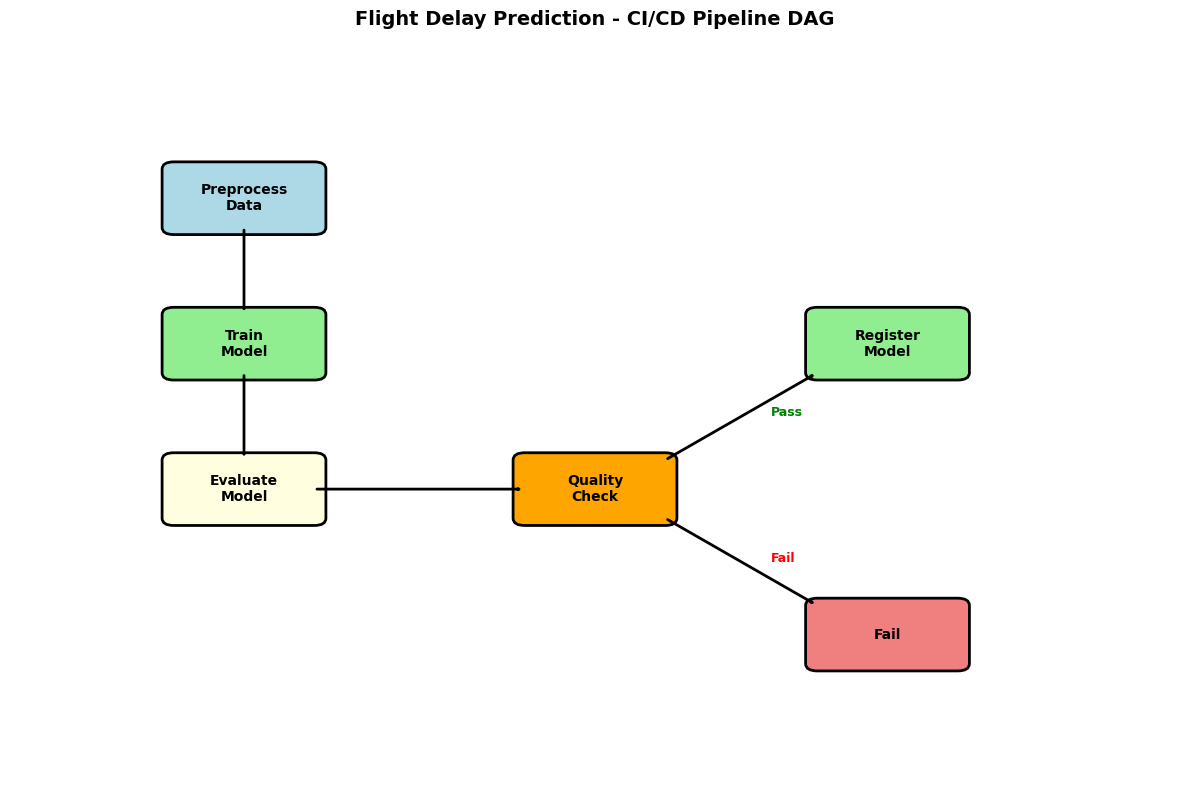

Pipeline DAG visualization saved as 'pipeline_dag.png'


In [22]:
# Create simple pipeline visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch

fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.axis('off')

# Define step positions
steps_info = [
    {"name": "Preprocess\nData", "pos": (2, 8), "color": "lightblue"},
    {"name": "Train\nModel", "pos": (2, 6), "color": "lightgreen"},
    {"name": "Evaluate\nModel", "pos": (2, 4), "color": "lightyellow"},
    {"name": "Quality\nCheck", "pos": (5, 4), "color": "orange"},
    {"name": "Register\nModel", "pos": (7.5, 6), "color": "lightgreen"},
    {"name": "Fail", "pos": (7.5, 2), "color": "lightcoral"}
]

# Draw steps
for step in steps_info:
    box = FancyBboxPatch(
        (step["pos"][0]-0.6, step["pos"][1]-0.4),
        1.2, 0.8,
        boxstyle="round,pad=0.1",
        edgecolor="black",
        facecolor=step["color"],
        linewidth=2
    )
    ax.add_patch(box)
    ax.text(step["pos"][0], step["pos"][1], step["name"],
            ha='center', va='center', fontsize=10, fontweight='bold')

# Draw arrows
arrows = [
    ((2, 7.6), (2, 6.4)),  # Preprocess -> Train
    ((2, 5.6), (2, 4.4)),  # Train -> Evaluate
    ((2.6, 4), (4.4, 4)),  # Evaluate -> Quality Check
    ((5.6, 4.4), (6.9, 5.6)),  # Quality Check -> Register (success)
    ((5.6, 3.6), (6.9, 2.4)),  # Quality Check -> Fail (failure)
]

for start, end in arrows:
    arrow = FancyArrowPatch(
        start, end,
        arrowstyle='->,head_width=0.4,head_length=0.8',
        color='black',
        linewidth=2
    )
    ax.add_patch(arrow)

# Add labels
ax.text(6.5, 5, 'Pass', fontsize=9, color='green', fontweight='bold')
ax.text(6.5, 3, 'Fail', fontsize=9, color='red', fontweight='bold')

plt.title('Flight Delay Prediction - CI/CD Pipeline DAG', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('pipeline_dag.png', dpi=150, bbox_inches='tight')
plt.show()

print("Pipeline DAG visualization saved as 'pipeline_dag.png'")

## 17. Save Pipeline Configuration

In [ ]:
# Update configuration
config['pipeline_name'] = pipeline_name
config['pipeline_arn'] = pipeline.pipeline_arn
config['latest_execution_arn'] = execution_arn
config['model_package_group_name'] = 'FlightDelayPredictionPackageGroup'

with open('config.json', 'w') as f:
    json.dump(config, f, indent=2)

print("Configuration updated and saved")

Configuration updated and saved


## Summary

In this notebook, we:
1. ✅ Created an end-to-end SageMaker Pipeline with 6 steps
2. ✅ Implemented preprocessing, training, and evaluation steps
3. ✅ Added conditional deployment based on quality thresholds
4. ✅ Created fail step for quality gates
5. ✅ Registered models in Model Registry
6. ✅ Tested both successful and failed pipeline executions
7. ✅ Visualized pipeline DAG

### Pipeline Components:
- **PreprocessFlightData:** Data preprocessing and feature engineering
- **TrainFlightDelayModel:** XGBoost model training
- **EvaluateModel:** Model evaluation on test set
- **CheckModelQuality:** Conditional step checking quality thresholds
- **RegisterFlightDelayModel:** Register model in Model Registry (if quality passes)
- **ModelQualityCheckFailed:** Fail step (if quality doesn't meet threshold)

### Next Steps:
Proceed to **05_batch_inference.ipynb** to:
- Create batch transform job for large-scale predictions
- Process batch flight data
- Compare batch vs real-time inference performance